<h1><center>Изучение закономерностей, определяющих успешность игр</center></h1>

---

## Описание данных

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы долларов)
- EU_sales — продажи в Европе (миллионы долларов)
- JP_sales — продажи в Японии (миллионы долларов)
- Other_sales — продажи в других странах (миллионы долларов)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Имопрт и загрузка

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from scipy import stats as st
from scipy.stats import norm
import math as mt

In [3]:
games = pd.read_csv('../../datasets/chapter_04.1_project_games.csv')

In [4]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


##  Предобработка данных

### `columns`
Первое, что бросается в глаза при визуальном просмотре данных - названия метрик с большой буквы. Исправим эту неприятность.

In [5]:
columns = [x.lower() for x in games.columns]
games.columns = columns

In [6]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Заметно, что данные не без пропусков. Где-то больше, где-то меньше, но пропуски есть. Буду разбираться с ними по ходу обработки данных. Пока делать какие-то выводы и гипотезы по пропускам слишком рано. 

Чтобы в дальнейшем было проще высматривать пропуски (и меньше копипастить код) сделаю функцию.

In [7]:
def my_nan(data, column):
    '''
    Функция принимает DataFrame и название столбца в котором надо проверить пропуски.
    Возвращает количество и % пропусков относительно всех даных в указанном столбце
    '''
    row_nan = data[column].isna().sum()
    row_total = len(data[column])
    result = row_nan / row_total   
    
    return print('Всего строк: {} \n'
                'Строк с NaN: {} или {:.2%}\n'.format(row_total, row_nan, result))


def my_nan_show(data, column):
    '''
    Функция принимает DataFrame и название столбца в котором надо проверить пропуски.
    Возвращает строки с пропусками
    '''
    return data[data[column].isna()==True]

### `name`
Чтобы избежать возможных проблем с дублями в названии игр переведу все названия в нижний регистр. Возможно, что данная процедура потребуется не один раз, поэтому оформлю все в функцию

In [8]:
def my_lower(data, *columns):
    '''
    Функция принимает DataFrame и названия столбцов в которых нужно произвести замену.
    В случае ошибки должно быть предупреждение, что что-то сломалось 
    '''
    
    for column in columns:
        try:
            data[column] = data[column].str.lower()  
        except:
            print('Что-то пошло не так')

In [9]:
my_lower(games, 'name')

Теперь изучим пропуски

In [10]:
my_nan(games, 'name')

Всего строк: 16715 
Строк с NaN: 2 или 0.01%



In [11]:
my_nan_show(games, 'name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Есть две игры без имени, жанра, оценок пользователей, критиков, рейтинга. Не думаю, что именно эти две игры помогут как-то решить поставленную задачу. Поэтому удалю данные строки из набора данных.

In [12]:
games = games[games['name'].isna()==False].copy()

### `platform`
Аналогичным образом поступлю и с данной метрикой. Заменю регистр на нижний и сделаю проверку на пропуски.

In [13]:
my_lower(games, 'platform')

In [14]:
my_nan(games, 'platform')

Всего строк: 16713 
Строк с NaN: 0 или 0.00%



Пропусков нет - отлично! 

### `year_of_release`

In [15]:
my_nan(games, 'year_of_release')

Всего строк: 16713 
Строк с NaN: 269 или 1.61%



Позволю себе удалить данные записи, так как восстановить год игры по косвенным признакам не получится. Да, есть несколько имен игр которые содержат год выпуска (как правило это спортивные игры). Но при визуальном просмотре я нашел только 7 таких игр. Знаний с регулярными выражениями пока не очень хватает, чтобы быстро вытащить эту год из строки с названием. Поэтому удаляю все 269 строк.

In [16]:
games = games[games['year_of_release'].isna()==False].copy()

Теперь самое время изменить формат данных. Так как изначально нам доступен только год выпуска игры, то нет смысла (как мне кажется) переводить данные в формат datetime. Достаточно будет обычного int64, чтобы была возможность работать с датами.

In [17]:
games['year_of_release'] = games['year_of_release'].astype('int64')

Также переименую данный столбец для краткости 

In [18]:
games.rename(columns={'year_of_release':'year'}, inplace=True)

### `genre`
Чтобы все было в едином стиле приведу к нижнему регистру записи и в данном столбце

In [19]:
my_lower(games, 'genre')

In [20]:
my_nan(games, 'genre')

Всего строк: 16444 
Строк с NaN: 0 или 0.00%



Пропусков нет - отлично!

### `na_sales`, `eu_sales`, `jp_sales`, `other_sales`
В рамках данного блока проверю все данные по продажам. Первым делом меня интересуют пропуски и аномальные значения.

In [21]:
games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   na_sales     16444 non-null  float64
 1   eu_sales     16444 non-null  float64
 2   jp_sales     16444 non-null  float64
 3   other_sales  16444 non-null  float64
dtypes: float64(4)
memory usage: 642.3 KB


In [22]:
games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].describe()

,na_sales,eu_sales,jp_sales,other_sales
count,16444.000000,16444.000000,16444.000000,16444.000000
mean,0.264012,0.145930,0.078487,0.047594
std,0.818378,0.506716,0.311100,0.188005
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.080000,0.020000,0.000000,0.010000
75%,0.240000,0.110000,0.040000,0.030000
max,41.360000,28.960000,10.220000,10.570000


Пропусков нет. А вот с распределением данных явно что-то не так. Средние значения всех метрик очень сильно отличаются от максимальных значений. Попробую разобраться в чем причина такого разброса.

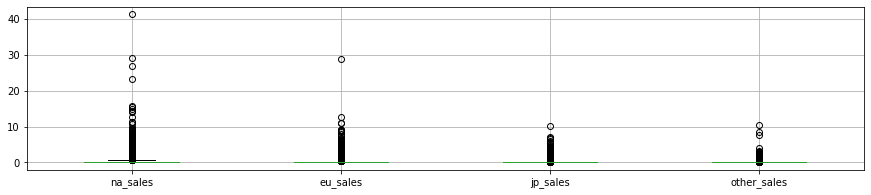

In [23]:
games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].boxplot(figsize=(15,3));

Видно, что в каждом регионе продаж есть супер-лидеры которые выглядят как аномалия, но таковой не являются. Похоже, что это просто супер успешные игры. Возможно, что стоит разделить весь набор данных на две части и проводить отдельный анализ супер-лидеров от других игр. Возможно, что и не стоит так делать. Пока есть ощущения, что эти супер-продажи могут сильно повлиять на итоговый результат если их никак не корректировать. Но я решил, на данном этапе, оставить данные как есть. Возможно далее я и сделаю какую-то разбивку. Буду смотреть по ситуации. 

Единственное, что я хочу сделать сейчас - добавить столбце `total_sales` и посчитать в него все продажи по каждой игре.

In [24]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

### `critic_score` 

In [25]:
my_nan(games, 'critic_score')

Всего строк: 16444 
Строк с NaN: 8461 или 51.45%



Больше 50% пропусков это конечно очень много. Возможно, что их можно обработать и заполнить медианными значениями в зависимости от года выпуска, жанра и платформы. Но есть риск, что потом эти медианные значения не позволят честно интерпретировать данные. Поэтому пока не буду никак обрабатывать и пытаться заполнить пропуски. Только заменю их на 0.

In [26]:
games['critic_score'].fillna(0, inplace=True)

### `user_score` 

In [27]:
my_nan(games, 'user_score')

Всего строк: 16444 
Строк с NaN: 6605 или 40.17%



Похоже, что и здесь аналогичная ситуация. Достаточно большое количество пропусков. Пока не буду пытаться восстановить эти данные. Сделаю замену на 0

In [28]:
games['user_score'].fillna(0, inplace=True)

Тип данных у этой переменной - object. Причина в том, что среди оценок пользователей встречается текст `tbd`. Если я правильно понял, то это аббревиатура означает или To Be Discussed, или To Be Determined. Получается, что играм с такой отметкой пользователи еще не поставили свою оценку. Поэтому буду считать, что у данной игры пользовательская оценка равна нулю. Сделаю соответствующую замену и переведу данные в тип float

In [29]:
len(games[games['user_score']=='tbd'])

2376

In [30]:
games.loc[(games['user_score']=='tbd'), 'user_score'] = 0

In [31]:
games['user_score'] = games['user_score'].astype('float64')

### `rating`

In [32]:
my_nan(games, 'rating')

Всего строк: 16444 
Строк с NaN: 6676 или 40.60%



In [33]:
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Похоже, что и в данном случае придется оставить пропуски без какой-то особой обработки. Если в случае с пользовательским рейтингом или рейтингом критиков можно представить вариант с заменой NaN на медиану. То в данном случае у меня совсем нет идей как можно заполнить данные значения. Привязываться к платформе/году выпуска/жанру совершенно точно не вариант. Так как эти показатели не влияют на возрастной рейтинг игры. 

Сделаю замену на 0, чтобы было проще и удобнее фильтровать данные и приведу запись к нижнему регистру.

In [34]:
games['rating'].fillna(0, inplace=True)

In [35]:
my_lower(games, 'rating')

В рамках работы по данному блоку было сделано следующее:
- названия столбцов и текстовых переменных (name, platform, genre, rating) были приведены к нижнему регистру. Сделал это для однообразия данных и для устранения возможных дублей из-за разного написания.
- `year_of_release` преобразовал тип данных к int64. Так как в предоставленных данных содержится только год выпуска игры, то не вижу смысла приводить данную метрику к формату datetime
- `user_score` преобразовал к типу данных float. Предварительно заменив текстовые значения на 0.
- пропуски обработал только в переменных `name` (было всего 2 записи) и `year_of_release` (удалил). Пропуски в метриках с рейтингами пользователей и критиков не обрабатывал. Есть подозрение, что замена на медианы по группам может сильно исказить общие выводы. Пока попробую обойтись без данной обработки. Возможная причина появления данных пропусков - ошибка в скриптах по сбору данных из сети.
- Дополнительно просчитал и добавил в набор данных продажи каждой игры во всех регионах.

## Исследовательский анализ данных

### Cколько игр выпускалось в разные годы. Важны ли данные за все периоды? 

In [36]:
# фильтрую нужные метрики
games_years = games.pivot_table(index='year', 
                                aggfunc={'total_sales':['count', 'sum']}).reset_index()
games_years.columns = ['year', 'count_games', 'total_sales']

In [37]:
def my_bar(date, column1, column2, column3 ):
    '''
    Функция строит график для сравнения двух параметров на одной оси:
    date = DataFrame
    column1 = метрику для оси Х
    column2 = первую метрику для оси У
    column3 = вторую метрику для очи У
    '''
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)

    # Переменные 
    x = date[column1]
    y = date[column2]
    y2 = date[column3]

    # Графики
    sales = ax.bar(x, y, alpha=1, label='Продажи')
    count = ax.bar(x, y2, alpha=0.3, label='Количество')

    # Улучшения  
    ax.set_title('Динамика выпуска и продаж игр', size=20)
    ax.set_ylabel('Продажи/Количество игр', size=15)
    ax.legend(fontsize=15)
    ax.grid(True)
    # Устанавливаю шаг для делений на оси и меняю их формат
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    for label in ax.get_xticklabels():
        label.set_rotation(90)

    plt.show();

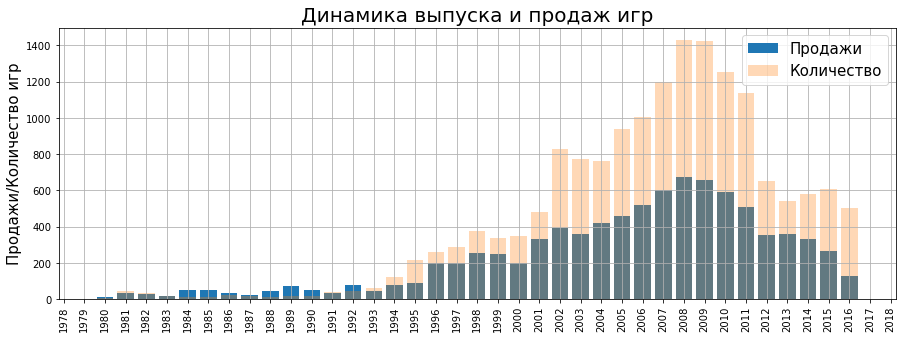

In [38]:
my_bar(games_years, 'year', 'total_sales', 'count_games')

Считаю, что максимально интересным для анализа является временной отрезок начиняя с 2002. Причина простая - именно с 2002 года начинается кратный рост по количеству выпускаемых игр. Растут и продажи, но конечно же не так как количество )

### Как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [39]:
years_total_sales = (games
                   .pivot_table(index=['platform', 'year'], aggfunc={'total_sales':'sum'})
                   .reset_index()
                  )

In [40]:
platforms_top = (years_total_sales
         .pivot_table(index=['platform'], aggfunc={'total_sales':'sum'})
         .reset_index()
         .sort_values(by='total_sales', ascending=False)
        )
platforms_top

,platform,total_sales
16,ps2,1233.56
28,x360,961.24
17,ps3,931.34
25,wii,891.18
4,ds,802.78
15,ps,727.58
18,ps4,314.14
6,gba,312.88
19,psp,289.53
2,3ds,257.81


Чтобы выбрать ТОП платформ использую квантиль. Считаю, что лидеры должны быть лидерами и должны показывать продажи лучше чем все в среднем.

In [41]:
q = platforms_top['total_sales'].quantile(0.75)
platforms_top = platforms_top[platforms_top['total_sales'] >= q].copy()

platforms_top_name = list(platforms_top['platform'].unique())

Пострю график по данным

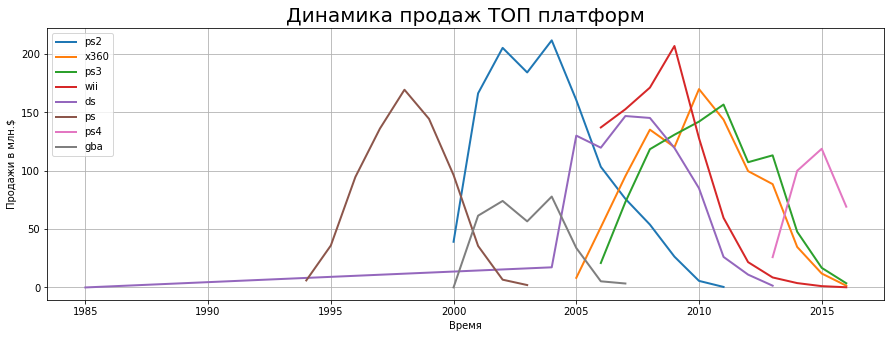

In [42]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

# Строю графики в цикле
for i in platforms_top_name:
    x = years_total_sales[years_total_sales['platform']==i]['year']
    y = years_total_sales[years_total_sales['platform']==i]['total_sales']

    line = ax.plot(x, y, '-', linewidth=2, label=i)

# Улучшения графика    
ax.set_title('Динамика продаж ТОП платформ', size=20)
ax.set_xlabel('Время')
ax.set_ylabel('Продажи в млн.$')
ax.legend()
ax.grid(True)
    # Устанавливаю шаг для делений на оси и меняю их формат
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    # for label in ax.get_xticklabels():
    #     label.set_rotation(90)
    #     label.set_fontsize(15)

plt.show();

График показывает ярко выраженный цикл смены лидеров платформ каждые пять лет. Получается, что раз в пять лет производители обновляют свою линейку приставок. Исключение, пожалуй, составляет только Nintendo DS. История приставки начинается в 1985. Судя по графику в 2004 они сделали сильное обновление своей консоли ) 

Мне кажется, что по данному графику можно сделать еще один интересный вывод. Начиная с 2005 года лидеры продаж не могут повторить успех прошлого периода(2000-2005). Скорее всего это связано с ростом количества платформ и «размыванием» аудитории по этим платформам. Не стоит забывать, что и мобильные устройства (телефоны/планшеты) тоже забирают какую-то долю пользователей.

### Выбор актуального периода для анализа

Учитывая результаты п3.1 и п3.2 я считаю актуальным периодом для анализа 2005 - 2015год. Главная цель проекта - прогноз продаж на 2017 год. Предположу, что для выполнения этой задачи нужно попробовать «передвинуть» историю 2005 на 2015.

In [43]:
target_year = games[(games['year']>=2005) & (games['year']<=2015)]

### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

In [44]:
table = target_year.pivot_table(index=['platform', 'year'], aggfunc={'total_sales':'sum'}).reset_index()
table.head()

,platform,year,total_sales
0,3ds,2011,63.20
1,3ds,2012,51.36
2,3ds,2013,56.57
3,3ds,2014,43.76
4,3ds,2015,27.78


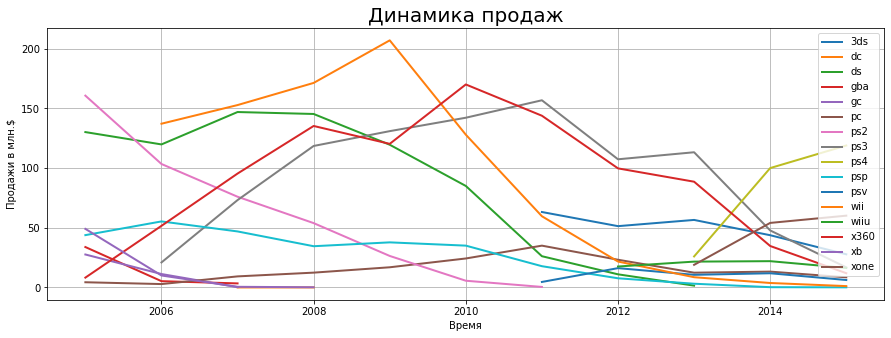

In [45]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

# Строю графики в цикле
for i in list(table['platform'].unique()):
    x = table[table['platform']==i]['year']
    y = table[table['platform']==i]['total_sales']

    line = ax.plot(x, y, '-', linewidth=2, label=i)

# Улучшения графика    
ax.set_title('Динамика продаж', size=20)
ax.set_xlabel('Время')
ax.set_ylabel('Продажи в млн.$')
ax.legend()
ax.grid(True)
    # Устанавливаю шаг для делений на оси и меняю их формат
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    # for label in ax.get_xticklabels():
    #     label.set_rotation(90)
    #     label.set_fontsize(15)

plt.show();

На анализируемом временном промежутке видно как набирают популярность и затем теряют ее (в рамках пятилетнего цикла) почти все платформы. Потенциально прибыльными выглядят только `ps4` и `xone`

### Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? Опишите результат.

In [46]:
# Скорее всего есть более элегантный способ проделать эту процедуру, но я пока не могу сообразить как. Поэтому делаю "в лоб"
platform_sales = (target_year
                  .pivot_table(index='name', columns=['platform'], aggfunc={'total_sales':'sum'})
                  .reset_index()
                 )

platform_sales.columns=['name', '3ds', 'dc', 'ds', 'gba', 'gc', 'pc', 'ps2', 'ps3', 
                        'ps4', 'psp', 'psv', 'wii', 'wiiu', 'x360', 'xb', 'xone']


total_platform_sales = target_year.pivot_table(index='name', aggfunc={'total_sales':'sum'}).reset_index()

platform_sales = platform_sales.merge(total_platform_sales, on='name')

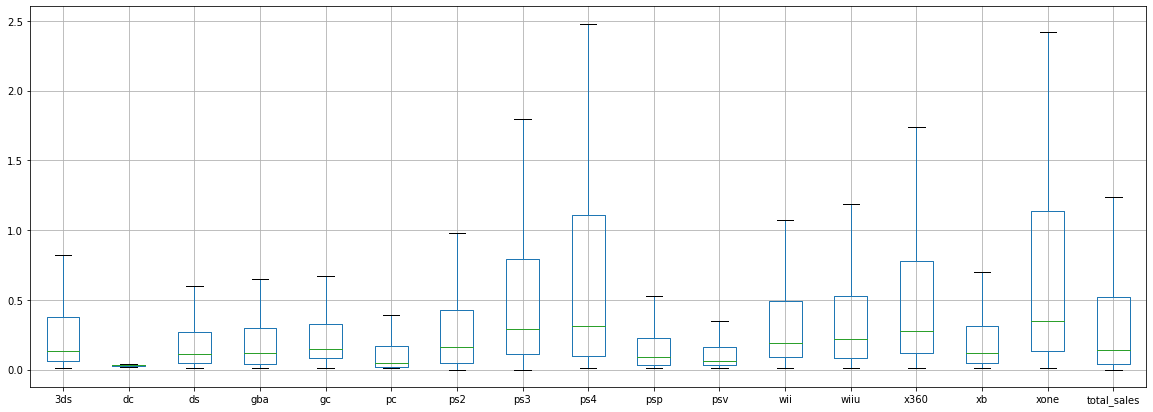

In [47]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)

platform_sales.boxplot(showfliers=False)

plt.show()

Если сравнивать глобальную продажу каждой игры и ее же продажу на конкретной платформе, то можно сказать следующее: есть существенные отличия в объеме продаж. Видимо это связано с эксклюзивными выпусками игр на определенных платформах. Тройка лидеров `xone`, `ps4`, `ps3`. Это справедливо как для абсолютных цифр, так и для средних значений.

### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Я решил рассмотреть влияние оценок пользователей и критиков на продажи платформы ps4. Так как рейтинги критиков и пользователей находятся в разных диапазонах (0-100 и 0-10), то приведу их к единой шкале, в диапазон от 0 до 10. Надеюсь, что так можно ) 

In [48]:
def my_scatter(x1, x2, y):
    fig = plt.figure(figsize=(20,10))

    ax1 = fig.add_subplot(211)
    ax1.scatter(x1, y)
    ax1.set_title('Зависимость продаж от оценки критиков', size=20)
    ax1.set_ylabel('Продажи в млн.$', size=15)
    ax1.grid(True)

    ax2 = fig.add_subplot(212)
    ax2.scatter(x2, y)
    ax2.set_title('Зависимость продаж от оценки игроков', size=20)
    ax2.set_ylabel('Продажи в млн.$', size=15)
    ax2.grid(True)

    plt.tight_layout(h_pad = 2)
    plt.show() 

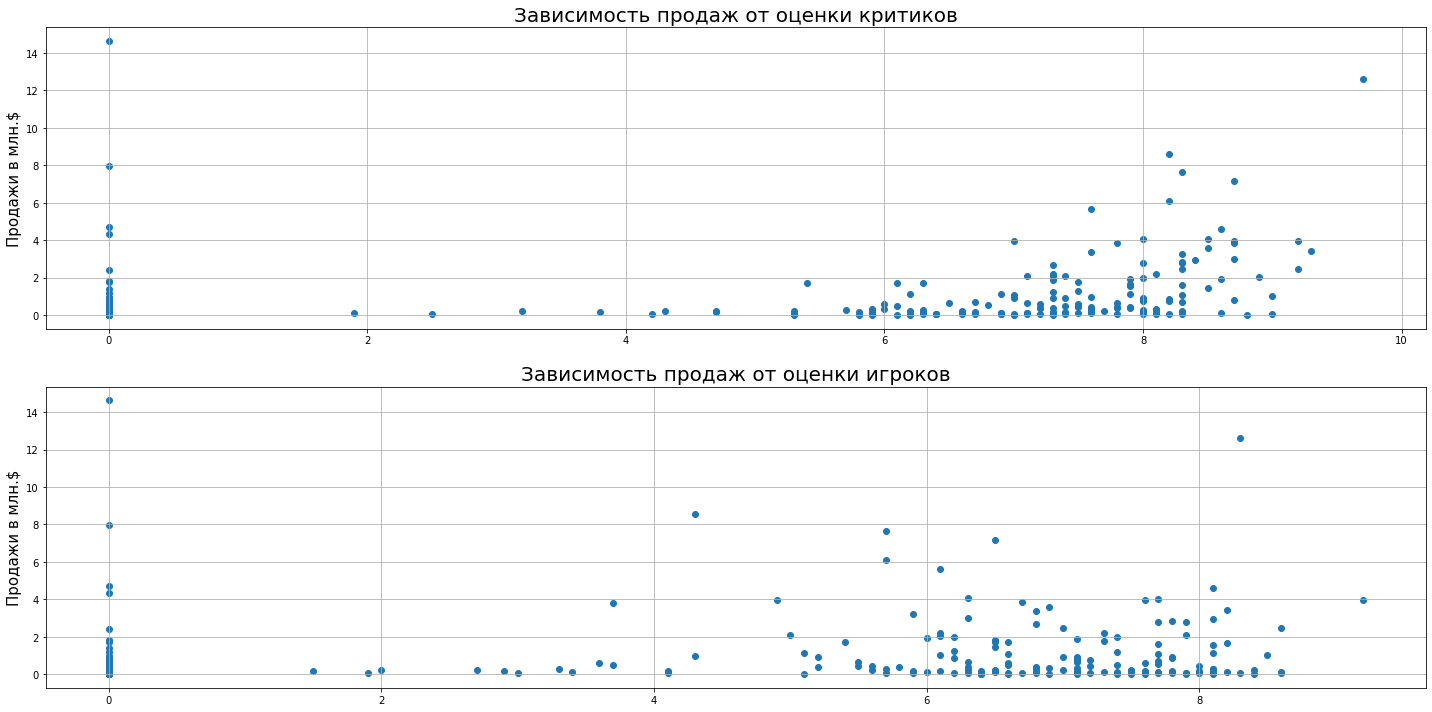

In [49]:
ps4 = target_year[target_year['platform']=='ps4'].copy()
ps4['critic_score'] = ps4['critic_score'] / 10
x1 = ps4['critic_score']
x2 = ps4['user_score']
y = ps4['total_sales']

my_scatter(x1,x2,y)

Предварительный вывод (по графикам) - отзывы критиков и игроков не оказывают слишком сильного влияние на продажи игр. Ну, или я не увидел здесь скрытой зависимости ) 
Что касается «левого» пика на обоих графиках - это пропущенные значения в данных по отзывам. Ранее заменил их на нули, вот они и вылезли. 

Посмотрим какие результаты покажет матрица корреляции 

In [50]:
ps4_table = ps4.pivot_table(index='name', values=['total_sales', 'critic_score', 'user_score'])
ps4_table.corr() 

,critic_score,total_sales,user_score
critic_score,1.000000,0.202074,0.927218
total_sales,0.202074,1.000000,0.098044
user_score,0.927218,0.098044,1.000000


Матрица корреляции подтверждает вывод сделаный на графиках. Ярко выраженной зависимости между отзывами (как пользователей, так и критиков) и продажами нет. А вот где просматривается какая-то связь, так это зависимость между самими отзывами )

### Соотнесите выводы с продажами игр на других платформах.

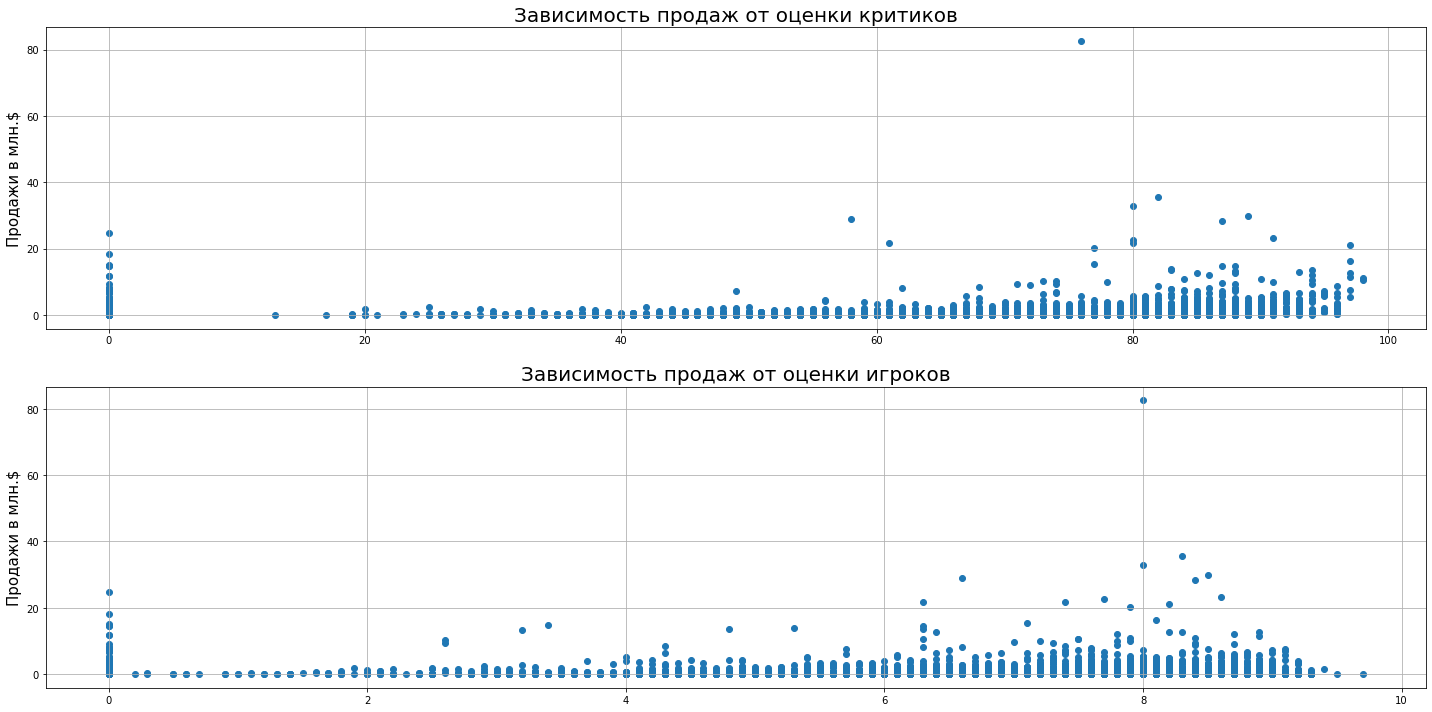

In [51]:
x1 = target_year['critic_score']
x2 = target_year['user_score']
y = target_year['total_sales']
my_scatter(x1,x2,y)

In [52]:
table = target_year.pivot_table(index='name', values=['total_sales', 'critic_score', 'user_score'])
table.corr() 

,critic_score,total_sales,user_score
critic_score,1.000000,0.198852,0.865474
total_sales,0.198852,1.000000,0.186202
user_score,0.865474,0.186202,1.000000


Если я правильно понял задачу данного блока, то получается, что выводы сделанные при анализе одной платформы (ps4) характерны и для всех платформ в целом. Ярко выраженной взаимосвязи между отзывами и продажами нет

### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [53]:
genre_table = (target_year
               .pivot_table(index='genre', aggfunc={'total_sales':['count', 'sum']})
               .reset_index())

genre_table.columns = ['genre', 'count', 'total_sales']
genre_table = genre_table.sort_values(by='total_sales', ascending=False)

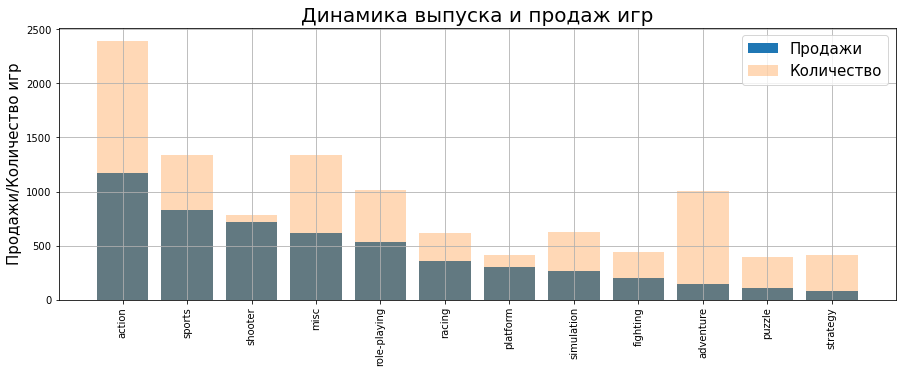

In [54]:
my_bar(genre_table, 'genre', 'total_sales', 'count')

Самые прибыльные жанры это `action`, `sports`, `shooter`. Самый не прибыльный жанр - `strategy`. Судя по графику можно выявить два интересных факта:
- `action` самый прибыльный и самый насыщенный жанр. Видимо производители игр тоже знают, что все максимум продаж происходит в этом жанре, вот и делают игры ) 
- `advenrure`, судя по всему, не требует сверх затрат на производство. Думаю, что именно это и объясняет такое соотношение количества игр к прибыли

В рамках работы по данному блоку было сделано следующее:
- выбран наиболее интересный временной отрезок для дальнейшего анализа (с 2002 года)
- выявлено, что каждые пять лет меняются лидеры продаж (платформы). 
- платформы которые показывают рост продаж (с 2013) это `ps4` и `Xone`. 
- выявлено, что выпуски эксклюзивных игр на платформе увеличивают рост продаж. 
- выявлено, что нет прямой связи между оценками критиков/пользователей и продажами
- выявлено, что самый прибыльный (и видимо самый конкурентный) жанр - `action`

## Составление портрета пользователя каждого региона

### Определите для пользователя каждого региона (NA, EU, JP): Самые популярные платформы (топ-5). Опишите различия в долях продаж.

Первым делом соберу нужную информацию в сводную таблицу и визуализирую результат.

In [55]:
region = (target_year
          .pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales'],aggfunc='sum')
          .reset_index()
         )
region

,platform,eu_sales,jp_sales,na_sales
0,3ds,58.94,92.59,78.51
1,dc,0.00,0.06,0.00
2,ds,184.48,171.35,371.98
3,gba,10.19,4.78,26.85
4,gc,7.47,2.78,27.97
5,pc,99.48,0.00,44.48
6,ps2,87.14,50.98,200.49
7,ps3,325.95,78.11,389.46
8,ps4,109.31,10.22,87.25
9,psp,63.92,73.85,105.02


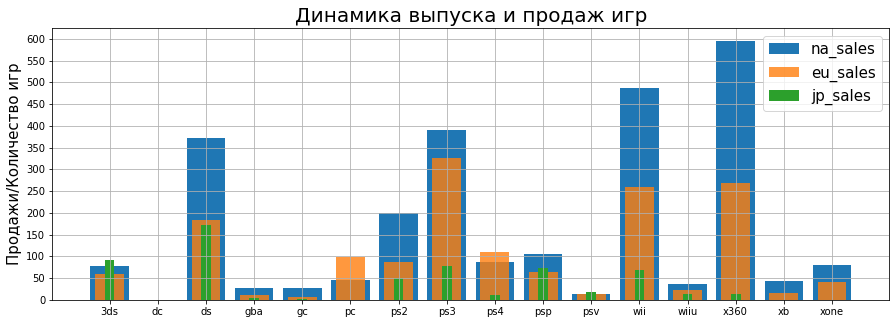

In [56]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

# Переменные 
x = list(region['platform'])
y1 = region['na_sales']
y2 = region['eu_sales']
y3 = region['jp_sales']

# Графики
ax.bar(x, y1, 0.8, alpha=1, label='na_sales')
ax.bar(x, y2, 0.6, alpha=0.8, label='eu_sales')
ax.bar(x, y3, 0.2, alpha=1, label='jp_sales')

# Улучшения  
ax.set_title('Динамика выпуска и продаж игр', size=20)
ax.set_ylabel('Продажи/Количество игр', size=15)
ax.grid()
ax.legend(fontsize=15)

# Устанавливаю шаг для делений на оси Y
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))

plt.show();

График, к сожалению, получился не очень читаемый (все еще продолжаю осваивать matplotlib). Но не смотря на это можно уверенно утверждать, что в популярность платформ в разных регионах отличается. Чтобы выбрать ТОП5 платформ для каждого региона использую таблицы.

In [57]:
# В сводную таблицу добавлю расчет доли продаж платформы в каждом регионе
na_sales_total = region['na_sales'].sum()
eu_sales_total = region['eu_sales'].sum()
jp_sales_total = region['jp_sales'].sum()

region['na_share'] = (region['na_sales'] / na_sales_total) * 100
region['eu_share'] = (region['eu_sales'] / na_sales_total) * 100
region['jp_share'] = (region['jp_sales'] / na_sales_total) * 100

region = region[['platform', 'na_sales', 'na_share', 'eu_sales', 'eu_share', 'jp_sales', 'jp_share']]

In [58]:
# Пожалуй и тут получилось не самое простое и изящное решение, но по другому пока не могу решить данную задачу )
na_salesTOP5 = region.sort_values(by='na_sales', ascending=False).head(5)[['platform', 'na_sales', 'na_share']]
eu_salesTOP5 = region.sort_values(by='eu_sales', ascending=False).head(5)[['platform', 'eu_sales', 'eu_share']]
jp_salesTOP5 = region.sort_values(by='jp_sales', ascending=False).head(5)[['platform', 'jp_sales', 'jp_share']]

region_platformTOP5 = pd.concat([na_salesTOP5, eu_salesTOP5, jp_salesTOP5], axis=0, sort=True)
region_platformTOP5 = region_platformTOP5[['platform', 'na_sales', 'na_share', 'eu_sales', 
                                           'eu_share', 'jp_sales', 'jp_share']]
region_platformTOP5

,platform,na_sales,na_share,eu_sales,eu_share,jp_sales,jp_share
13,x360,595.05,23.029231,NaN,NaN,NaN,NaN
11,wii,486.81,18.840198,NaN,NaN,NaN,NaN
7,ps3,389.46,15.072623,NaN,NaN,NaN,NaN
2,ds,371.98,14.396124,NaN,NaN,NaN,NaN
6,ps2,200.49,7.759231,NaN,NaN,NaN,NaN
7,ps3,NaN,NaN,325.95,12.614701,NaN,NaN
13,x360,NaN,NaN,267.61,10.356865,NaN,NaN
11,wii,NaN,NaN,258.21,9.993072,NaN,NaN
2,ds,NaN,NaN,184.48,7.139623,NaN,NaN
8,ps4,NaN,NaN,109.31,4.230443,NaN,NaN


Собственно таблица подтвердила график, но теперь можно детализировать информацию и дат более точные ответы:
- `na_sales` лидеры по продажам `x360`, `wii`, `ps3`, `ds`, `ps2`. Интересно, что данные платформы занимают совокупную долю в 79% всех продаж рассматриваемого региона.
- `eu_sale` лидеры по продажам `ps3`, `x306`, `wii`, `ds`, `ps4`. Интересно, что данные платформы занимают совокупную долю в 44% всех продаж рассматриваемого региона.
- `jp_sale` лидеры по продажам `ds`, `3ds`, `ps3`, `psp`, `wii`. Интересно, что данные платформы занимают совокупную долю в 18% всех продаж рассматриваемого региона.

Пожалуй главный вывод который напрашивается по итогам данного раздела - европейский и японский рынок игровых приставок более конкурентен чем в США. ТОП5 платформ удерживают совокупную долю продаж сильно меньше чем в США

### Определите для пользователя каждого региона (NA, EU, JP): Самые популярные жанры (топ-5). Поясните разницу.

In [59]:
genre = (target_year
          .pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'],aggfunc='sum')
          .reset_index()
         )
genre

,genre,eu_sales,jp_sales,na_sales
0,action,361.90,101.32,570.75
1,adventure,38.61,29.09,65.62
2,fighting,45.75,30.93,102.79
3,misc,166.43,71.45,311.06
4,platform,85.54,36.21,148.46
5,puzzle,33.80,18.64,49.03
6,racing,127.28,17.56,162.85
7,role-playing,111.24,172.99,205.96
8,shooter,232.17,19.61,384.72
9,simulation,84.75,32.00,126.79


In [60]:
# В сводную таблицу добавлю расчет доли продаж жанра в каждом регионе
na_sales_total = genre['na_sales'].sum()
eu_sales_total = genre['eu_sales'].sum()
jp_sales_total = genre['jp_sales'].sum()

genre['na_share'] = (genre['na_sales'] / na_sales_total) * 100
genre['eu_share'] = (genre['eu_sales'] / na_sales_total) * 100
genre['jp_share'] = (genre['jp_sales'] / na_sales_total) * 100

genre = genre[['genre', 'na_sales', 'na_share', 'eu_sales', 'eu_share', 'jp_sales', 'jp_share']]

# Продублирую не самый оптимальный вараинт  )
na_genreTOP5 = genre.sort_values(by='na_sales', ascending=False).head(5)[['genre', 'na_sales', 'na_share']]
eu_genreTOP5 = genre.sort_values(by='eu_sales', ascending=False).head(5)[['genre', 'eu_sales', 'eu_share']]
jp_genreTOP5 = genre.sort_values(by='jp_sales', ascending=False).head(5)[['genre', 'jp_sales', 'jp_share']]

region_genreTOP5 = pd.concat([na_genreTOP5, eu_genreTOP5, jp_genreTOP5], axis=0, sort=True)
region_genreTOP5 = region_genreTOP5[['genre', 'na_sales', 'na_share', 'eu_sales', 
                                           'eu_share', 'jp_sales', 'jp_share']]
region_genreTOP5

,genre,na_sales,na_share,eu_sales,eu_share,jp_sales,jp_share
0,action,570.75,22.088789,NaN,NaN,NaN,NaN
10,sports,425.16,16.454261,NaN,NaN,NaN,NaN
8,shooter,384.72,14.889179,NaN,NaN,NaN,NaN
3,misc,311.06,12.038438,NaN,NaN,NaN,NaN
7,role-playing,205.96,7.970928,NaN,NaN,NaN,NaN
0,action,NaN,NaN,361.90,14.006014,NaN,NaN
10,sports,NaN,NaN,253.60,9.814659,NaN,NaN
8,shooter,NaN,NaN,232.17,8.985290,NaN,NaN
3,misc,NaN,NaN,166.43,6.441064,NaN,NaN
6,racing,NaN,NaN,127.28,4.925906,NaN,NaN


Получилось очень интересно ) 
Интересы пользователей США и Европы совпадают почти полностью. Отличие только в 5ой позиции в ТОП5 жанров. А вот японский рынок отличается и очень сильно. 
Забавно, но и здесь (как и с платформами) тенденция по занимаемо доли рынка совпадает. 
- США 73% всех продаж приходятся на ТОП5 жанров
- Европа 44% всех продаж приходятся на ТОП5 жанров
- Япония 17% всех продаж приходятся на ТОП5 жанров

### Определите для пользователя каждого региона (NA, EU, JP): Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [61]:
rating = (target_year
          .pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'],aggfunc='sum')
          .reset_index()
         )
rating

,rating,eu_sales,jp_sales,na_sales
0,ao,0.61,0.00,1.26
1,e,495.10,146.26,865.13
2,e10+,178.11,38.60,339.21
3,ec,0.11,0.00,1.53
4,m,397.57,45.03,591.67
5,rp,0.03,0.00,0.00
6,t,248.38,89.05,470.13


Чтобы было удобнее и проще анализировать рейтинг сделаю замену названий на полноценное и добавлю нумерацию

In [62]:
rating.loc[rating['rating']=='ec', 'rating'] = '01_early childhood'
rating.loc[rating['rating']=='e', 'rating'] = '02_everyone'
rating.loc[rating['rating']=='e10+', 'rating'] = '03_everyone 10 and older'
rating.loc[rating['rating']=='t', 'rating'] = '04_teen'
rating.loc[rating['rating']=='m', 'rating'] = '05_mature'
rating.loc[rating['rating']=='ao', 'rating'] = '06_adults only 18+'
rating.loc[rating['rating']=='rp', 'rating'] = '07_rating pending'

rating.sort_values(by='rating')

,rating,eu_sales,jp_sales,na_sales
3,01_early childhood,0.11,0.00,1.53
1,02_everyone,495.10,146.26,865.13
2,03_everyone 10 and older,178.11,38.60,339.21
6,04_teen,248.38,89.05,470.13
4,05_mature,397.57,45.03,591.67
0,06_adults only 18+,0.61,0.00,1.26
5,07_rating pending,0.03,0.00,0.00


Судя по таблице можно сделать следующие выводы.
- США. Игры с рейтингом `everyone` продаются лучше всех. На втором месте идет `mature`. Третье место у `tenn`
- Европа. Игры с рейтингом `everyone` продаются лучше всех. На втором месте идет `mature`. Третье место у `tenn`. Точная копия американского рынка ) 
- Япония. Игры с рейтингом `everyone` продаются лучше всех. На втором месте идет `teen`. Третье место у `mature`. Японцы, как всегда, отличились )

В рамках работы по данному блоку было сделано сделано следующее: 
- выявлены самые популярные платформы (ТОП5) в зависимости от региона продаж
- выявлены самые популярные жанры (ТОП5) в зависимости от региона продаж 
- выявлены самые популярные игровые рейтинги (по продажам) в зависимости от региона продаж.

## Построение гипотез и проверка

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформулирую гипотезы:
- __нулевая__: cредние пользовательские рейтинги платформ Xbox One и PC одинаковые
- __альтернативная__: средние пользовательские рейтинги платформ Xbox One и PC не одинаковые

Критический уровень статистической значимости решил принять в 5%. Если я правильно понял теорию, то это стандарт. Если p-value окажется меньше данного значения - это будет означать, что нулевая гипотеза должна быть отвергнута. В качестве само проверки) проверить гипотезы несколькими вариантами.

In [63]:
# отбираю данные для проверки гипотезы
xone_userscore = target_year[target_year['platform']=='xone']['user_score']
pc_userscore = target_year[target_year['platform']=='pc']['user_score']

# заодно посмотрю на средние значения сам 
xone_userscore_mean = target_year[target_year['platform']=='xone']['user_score'].mean()
pc_userscore_mean = target_year[target_year['platform']=='pc']['user_score'].mean()

print('Средние пользовательские рейтинги платформ Xbox One: {:.3}\n'
     'Средние пользовательские рейтинги платформ PC: {:.2}'.format(xone_userscore_mean, pc_userscore_mean))

Средние пользовательские рейтинги платформ Xbox One: 4.7
Средние пользовательские рейтинги платформ PC: 5.5


In [64]:
alpha = .05

results = st.ttest_ind(
    xone_userscore, 
    pc_userscore)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.004526087316907866
Отвергаем нулевую гипотезу


__Ответ__  
Проверка гипотезы (и визуальная проверка) показала, что средние пользовательские рейтинги не одинаковые. Пользователи PC чаще ставят более высокую оценку игре.

### Средние пользовательские рейтинги жанров Action и Sports разные.

Сформулирую гипотезы:
- __нулевая__: cредние пользовательские рейтинги жанров Action и Sports одинаковые
- __альтернативная__: средние пользовательские рейтинги жанров Action и Sports не одинаковые

In [65]:
# отбираю данные для проверки гипотезы
action_userscore = target_year[target_year['genre']=='action']['user_score']
sports_userscore = target_year[target_year['genre']=='sports']['user_score']

# заодно посмотрю на средние значения сам 
action_userscore_mean = target_year[target_year['genre']=='action']['user_score'].mean()
sports_userscore_mean = target_year[target_year['genre']=='sports']['user_score'].mean()

print('Средние пользовательские рейтинги жанра Action: {:.3}\n'
     'Средние пользовательские рейтинги жанра Sports: {:.2}'.format(action_userscore_mean, sports_userscore_mean))

Средние пользовательские рейтинги жанра Action: 4.01
Средние пользовательские рейтинги жанра Sports: 3.6


In [66]:
alpha = .05

results = st.ttest_ind(
    action_userscore, 
    sports_userscore)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.00022538410662854266
Отвергаем нулевую гипотезу


__Ответ__  
Проверка гипотезы (и визуальная проверка) показала, что средние пользовательские рейтинги не одинаковые. Игры жанра Action чаще получают более высокие оценки. 

В рамках данного блока работы были опровергнуты нулевые гипотезы для всех выдвинутых теорий. В результате можно утверждать, что средние пользовательские рейтинги платформ `Xbox One` и `PC` не одинаковые. И средние пользовательские рейтинги жанров `Action` и `Sports` разные.

## Итоговый выводы

Основные выводы по проделанной работе:
- раз в пять лет, как правило, происходит смена платформы лидера. Сейчас (в конце 2016) максимально привлекательными выглядят следующие платформы: `ps4` и `xone`.  
- эксклюзивные игры на консоли (ps4, ps3, xone, x360) драйвят продажи на этих приставках лучше чем в среднем по всем платформам. 
- рекомендации пользователей и критиков не оказывают заметного (сильного) влияния на продажи игр. Эта закономерность прослеживается как на платформе из списка ТОП, так и в целом по всем платформам. 
- ТОП3 самых продаваемых жанра игр (по всем регионам): `action`, `sports`, `shooter`.
- если оценивать рынки с точки зрения популярности платформ (доля продаж в регионе), то
- - США: `x360`, `wii`, `ps3`
- - Европа: `ps3`, `x360`, `wii`
- - Япония: `ds`, `3ds`, `ps3`
-  если оценивать рынки с точки зрения популярности жанров (доля продаж в регионе), то:
- - США: `action`, `sport`, `shooter`
- - Европа: `action`, `sport`, `shooter`
- - Япония: `role-playing`, `action`, `misc`
- популярность игр в зависимости от рейтинга ESRB:
- - США: `everyone`, `mature`, `teen`
- - Европа: `everyone`, `mature`, `teen`
- - Япония: `everyone`, `teen`, `mature`

Напомню, что главный вопрос всего проекта: нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании

Отвечая на данный вопрос я бы выделил следующие рекомендации для планирования рекламных кампаний.
- нужно делать ставку на игры для приставок. Будет очень здорово, если будет возможность продавать и эксклюзивные релизы. 
- обязательно стоит учесть региональные предпочтения к платформам и жанрам. Как было показано выше рынки США и Европы очень похожи, а вот Япония отличается. 
- для потенциального увеличения продаж лучше всего рекламировать игры с рейтингом `everyone`, `mature`, `teen`